# Import libraries

In [1]:
import sys
from pathlib import Path
sys.path.insert(0,'..')
import glob
#!pip install openpyxl

In [2]:
import os
import sys
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import h5py
import re

from functools import partial
from multiprocessing import Pool

from lhcsmapi.Time import Time
from lhcsmapi.Timer import Timer
from lhcsmapi.metadata.MappingMetadata import MappingMetadata
from scipy import signal
import xarray as xr

from src.utils.utils import log_acquisition
from src.utils.hdf_tools import acquisition_to_hdf5, load_from_hdf_with_regex
from src.visualisation.sec_quench_visualisation import plot_wiggle_analysis
from src.modeling.sec_quench import *
from src.utils.dataset_utils import *
from src.utils.utils import interp

pd.set_option('display.max_rows', 200)
import warnings
warnings.filterwarnings('ignore')
#%matplotlib widget
#%matplotlib inline
#%load_ext autoreload

# Define Paths

In [3]:
file_path  = Path('/eos/project/m/ml-for-alarm-system/private/RB_signals')
data_path = file_path / 'backup/20220707_data'
simulation_path = file_path / 'backup/20220707_simulation'

# Read the (clean) MP3 file

In [4]:
mp3_fpa_df = pd.read_csv("../data/RB_TC_extract_2022_07_07_processed_filled.csv")
len(mp3_fpa_df)

3981

# Read metadata

In [5]:
metadata_path = Path("../data/RB_metadata.csv")
rb_magnet_metadata = pd.read_csv(metadata_path, index_col=False)
rb_magnet_metadata

,Circuit,Magnet,Position,B1_aperture,Diode_type,Correctors,EE place,#Electric_EE,#Electric_circuit,Cryostat,...,Dcum2,QPS Crate,QPS Board,#Segment,phys_pos,Name,R_1,R_2,RRR_1,RRR_2
0,RB.A12,MB.A8R1,276.7340,EXT,R,A,EVEN,1,78,LBARE.8R1,...,268.9040,B8R1,0,79,1,A8R1,1.80,1.85,95.650088,94.103943
1,RB.A12,MB.B8R1,292.3940,EXT,R,B,ODD,77,77,LBBRF.8R1,...,284.5640,B9R1,0,77,2,B8R1,1.67,1.85,100.314516,94.103943
2,RB.A12,MB.A9R1,315.7990,EXT,R,A,EVEN,2,79,LBARE.9R1,...,307.9690,B8R1,1,80,3,A9R1,1.75,1.85,97.936878,94.103943
3,RB.A12,MB.B9R1,331.4590,EXT,R,B,ODD,76,76,LBBRG.9R1,...,323.6290,B11R1,2,76,4,B9R1,1.67,1.77,100.314516,97.371760
4,RB.A12,MB.A10R1,356.2640,EXT,R,A,EVEN,3,80,LBARE.10R1,...,348.4340,B10R1,0,81,5,A10R1,1.67,1.67,100.314516,100.314516
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1227,RB.A81,MB.A10L1,26302.6192,INT,L,B,ODD,75,75,LBBLG.10L1,...,26294.7892,B10L1,1,75,150,A10L1,2.53,3.13,78.314002,70.353447
1228,RB.A81,MB.B9L1,26327.4242,INT,L,A,EVEN,2,79,LBALE.9L1,...,26319.5942,B9L1,1,80,151,B9L1,3.25,3.70,68.099268,54.735949
1229,RB.A81,MB.A9L1,26343.0842,INT,L,B,ODD,76,76,LBBLF.9L1,...,26335.2542,B10L1,2,76,152,A9L1,3.09,1.75,70.748254,99.628927
1230,RB.A81,MB.B8L1,26366.4892,INT,L,A,EVEN,1,78,LBALE.8L1,...,26358.6592,B9L1,0,79,153,B8L1,2.43,2.43,79.915648,79.899869


In [6]:
rb_magnet_metadata[rb_magnet_metadata['Circuit']=='RB.A12'].sort_values(by='#Electric_circuit')[['QPS Crate','#Electric_EE','Magnet']]

,QPS Crate,#Electric_EE,Magnet
153,B8L2,1,MB.A8L2
151,B8L2,2,MB.A9L2
149,B10L2,3,MB.A10L2
147,B10L2,4,MB.A11L2
145,B10L2,5,MB.A12L2
143,B12L2,6,MB.C12L2
141,B12L2,7,MB.B13L2
139,B12L2,8,MB.A14L2
137,B14L2,9,MB.C14L2
135,B14L2,10,MB.B15L2


# Select events to analyze

In [6]:
mp3_fpa_df_unique = mp3_fpa_df.drop_duplicates(subset=['timestamp_fgc', 'Circuit Name'])
lower_limit = Time.to_unix_timestamp('2014-01-01 00:00:00+01:00')
mp3_fpa_df_period = mp3_fpa_df_unique[mp3_fpa_df_unique['timestamp_fgc'] >= lower_limit].reset_index(drop=True) 

mp3_fpa_df_period_all = mp3_fpa_df[mp3_fpa_df['timestamp_fgc'] >= lower_limit].reset_index(drop=True) 
print(len(mp3_fpa_df_period), len(mp3_fpa_df_period_all))

822 3981


In [7]:
# Add information, whether download was successfull
df_acquisition = pd.read_excel("../data/20220707_acquisition_summary.xlsx")
mp3_fpa_df_period_merged = mp3_fpa_df_period.merge(df_acquisition , left_on=['Circuit Name', 'timestamp_fgc'], right_on=['Circuit Name', 'timestamp_fgc'], how="left")
df_to_analyze = mp3_fpa_df_period_merged[mp3_fpa_df_period_merged['VoltageNQPS.*U_DIODE']==1]
len(df_to_analyze)

563

# Analyze all events

In [178]:
fpa_identifier = "RB_RB.A78_1636740012620000000"    
circuit_name = fpa_identifier.split("_")[1]
timestamp_fgc = int(fpa_identifier.split("_")[2])

mp3_fpa_df_subset = mp3_fpa_df[(mp3_fpa_df.timestamp_fgc == timestamp_fgc) & 
                               (mp3_fpa_df['Circuit Name'] == circuit_name)]

In [179]:
def get_similarity_df(df):
    combinations = []
    for c in df.columns: 
        for j in df.columns:
            if j!=c and not (j + '-' + c in combinations):
                combinations.append(c + '-' + j)

    similarity = np.array([df[c.split('-')[0]].values - df[c.split('-')[1]].values for c in combinations])
    df_similarity = pd.DataFrame(similarity.T, columns=combinations, index=df.index)
    return df_similarity

In [180]:
all_quenched_magnets = mp3_fpa_df_subset.Position.values
quench_times = mp3_fpa_df_subset["Delta_t(iQPS-PIC)"].values / 1e3

# load data
data_dir = data_path / (fpa_identifier + ".hdf5")
data = load_from_hdf_with_regex(file_path=data_dir, regex_list=['VoltageNQPS.*U_DIODE'])
df_data = u_diode_data_to_df(data, len_data=len(data[0]))

# load simulation
simulation_dir = simulation_path / (fpa_identifier + ".hdf")
data_sim = load_from_hdf_with_regex(file_path=simulation_dir, regex_list=["0v_magf"])
df_sim = u_diode_simulation_to_df(data_sim, circuit_name=mp3_fpa_df_subset["Circuit Name"].values[0])

# save magnet order for later usage
magnet_list = df_sim.columns

# drop quenched magnet
max_time = df_data.index.max()
df_data_noq = drop_quenched_magnets(df_data, all_quenched_magnets, quench_times, max_time)
df_sim_noq = drop_quenched_magnets(df_sim, all_quenched_magnets, quench_times, max_time)

# sometimes only noise is stored, mean must be in window -1, -10
mean_range = [-1.5, -10]
df_data_noq = df_data_noq.drop(
    df_data_noq.columns[~(mean_range[0] > df_data_noq.mean()) | (mean_range[1] > df_data_noq.mean())],
    axis=1)

# align with energy extraction timestamp
ee_margins = [-0.25, 0.25]
t_first_extraction = min(float(mp3_fpa_df_subset['Delta_t(EE_odd-PIC)'].values[0]) / 1000,
                         float(mp3_fpa_df_subset['Delta_t(EE_even-PIC)'].values[0]) / 1000)
df_data_aligned = align_u_diode_data(df_data=df_data_noq.copy(),
                                     t_first_extraction=t_first_extraction,
                                     ee_margins=ee_margins)

# filter data with 20ms mean filter of sunglasses
t_filter = 0.02 #20ms mean filter
samples_filter =  t_filter / (df_data_aligned.index.values[1] - df_data_aligned.index.values[0])
df_data_filtered = df_data_aligned.rolling(int(samples_filter)).mean()


t_sunglass_activation_magnet = df_data_filtered[df_data_filtered < -1.55].apply(lambda x: x.first_valid_index(), axis=0)

# cut out time frame to analyze
time_frame = [t_sunglass_activation_magnet.min(), t_sunglass_activation_magnet.min()+1.3]
df_data_cut = get_df_time_window(df=df_data_filtered,
                                 timestamp=0,
                                 time_frame=time_frame)#,
                                 #n_samples=n_samples)

# adjust simulation length to data
df_sim_noq_resampled = interp(df_sim_noq, df_data_cut.index)
df_sim_noq_resampled = df_sim_noq_resampled.rolling(int(samples_filter)).mean()

# add quenched magnets again for continuity
dropped_columns_data = magnet_list[~magnet_list.isin(df_data_cut.columns)]
dropped_columns_simulation = magnet_list[~magnet_list.isin(df_sim_noq_resampled.columns)]
df_data_cut[dropped_columns_data] = np.nan
df_sim_noq_resampled[dropped_columns_simulation] = np.nan
# bring into electrical order again
df_data_cut = df_data_cut[magnet_list]
df_sim_noq_resampled = df_sim_noq_resampled[magnet_list]

#calculate different crates
crates = rb_magnet_metadata[rb_magnet_metadata['Circuit'] == mp3_fpa_df_subset["Circuit Name"].values[0]]['QPS Crate'].unique()
crate_magents = [rb_magnet_metadata[rb_magnet_metadata['QPS Crate'] == c]['Magnet'].values +':U_DIODE_RB' for c in crates]
# TODO: ref_magnets is only a placeholder for now
next_crate = np.roll(crates,1)
ref_magnets =  [rb_magnet_metadata[rb_magnet_metadata['QPS Crate'] == c]['Magnet'].values[0] +':U_DIODE_RB' for c in next_crate] 
crate_magents_ref = [np.append(crate_magents[i], ref_magnets[i]) for i, c in enumerate(crate_magents)]
df_data_crate_similarity = pd.concat([get_similarity_df(df_data_cut[c]) for c in crate_magents_ref], axis=1)
df_sim_crate_similarity = pd.concat([get_similarity_df(df_sim_noq_resampled[c]) for c in crate_magents_ref], axis=1)

In [197]:
# load data
data_dir = data_path / (fpa_identifier + ".hdf5")
data = load_from_hdf_with_regex(file_path=data_dir, regex_list=['VoltageNQPS.*U_DIODE'])
df_data = u_diode_data_to_df(data, len_data=len(data[0]))

# load simulation
simulation_dir = simulation_path / (fpa_identifier + ".hdf")
data_sim = load_from_hdf_with_regex(file_path=simulation_dir, regex_list=["0v_magf"])
df_sim = u_diode_simulation_to_df(data_sim, circuit_name=mp3_fpa_df_subset["Circuit Name"].values[0])

# save magnet order for later usage
magnet_list = df_sim.columns

# drop quenched magnet
max_time = df_data.index.max()
df_data_noq = drop_quenched_magnets(df_data, all_quenched_magnets, quench_times, max_time)
df_sim_noq = drop_quenched_magnets(df_sim, all_quenched_magnets, quench_times, max_time)

# sometimes only noise is stored, mean must be in window -1, -10
mean_range = [-1.5, -10]
df_data_noq = df_data_noq.drop(
    df_data_noq.columns[~(mean_range[0] > df_data_noq.mean()) | (mean_range[1] > df_data_noq.mean())],
    axis=1)

# align with energy extraction timestamp
ee_margins = [-0.25, 0.25]
t_first_extraction = get_u_diode_data_alignment_timestamps(df_sim_noq, ee_margins=ee_margins)
df_data_aligned = align_u_diode_data(df_data=df_data_noq.copy(),
                                     t_first_extraction=t_first_extraction,
                                     ee_margins=ee_margins)

# cut out time frame to analyze
t_first_extraction = min(float(mp3_fpa_df_subset['Delta_t(EE_odd-PIC)'].values[0]) / 1000,
                         float(mp3_fpa_df_subset['Delta_t(EE_even-PIC)'].values[0]) / 1000)
time_frame = [0.65, 0.95]
n_samples = 660
df_data_cut = get_df_time_window(df=df_data_aligned,
                                 timestamp=t_first_extraction,
                                 time_frame=time_frame,
                                 n_samples=n_samples)

# adjust simulation length to data
df_sim_noq_resampled = interp(df_sim_noq, df_data_cut.index)

# add quenched magnets again for continuity
dropped_columns_data = magnet_list[~magnet_list.isin(df_data_cut.columns)]
dropped_columns_simulation = magnet_list[~magnet_list.isin(df_sim_noq_resampled.columns)]
df_data_cut[dropped_columns_data] = np.nan
df_sim_noq_resampled[dropped_columns_simulation] = np.nan
# bring into electrical order again
df_data_cut = df_data_cut[magnet_list]
df_sim_noq_resampled = df_sim_noq_resampled[magnet_list]

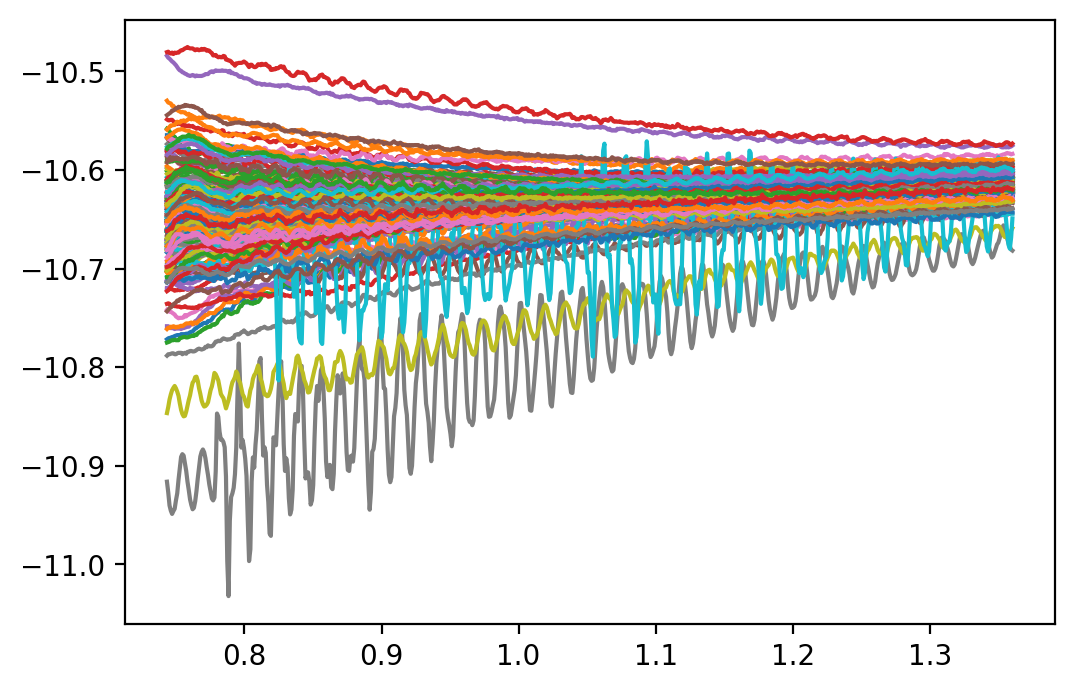

In [198]:
df_data_cut.plot(legend=False)

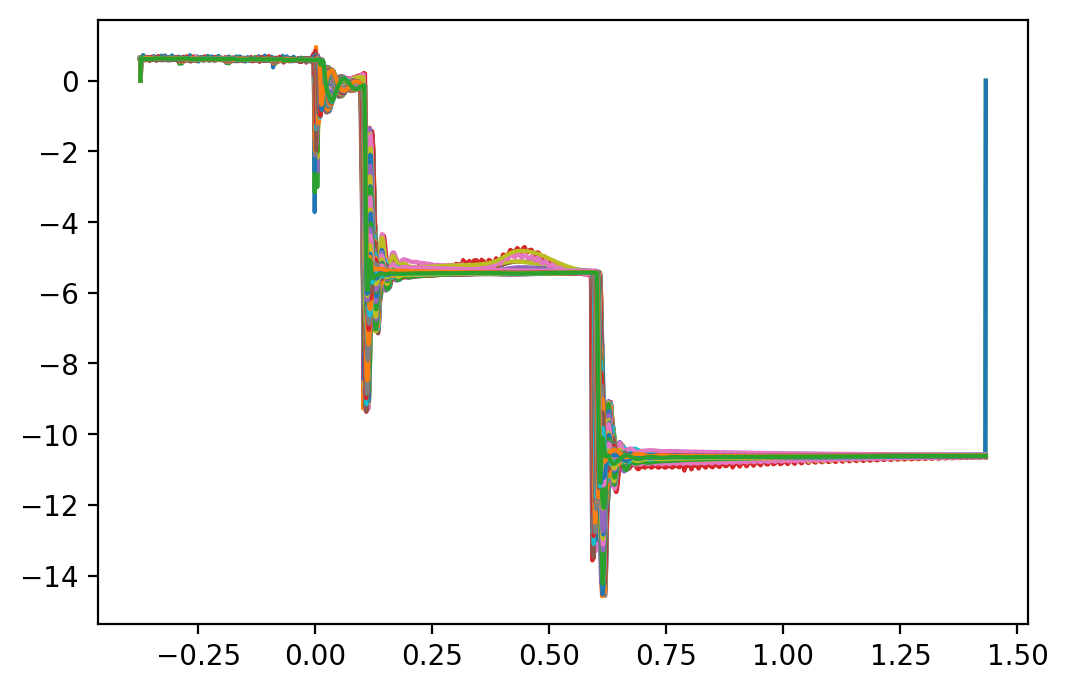

In [196]:
df_data_aligned.plot(legend=False) 

In [ ]:
df_sim_crate_similarity.plot(legend=False) 

In [ ]:
df_data_cut.plot(legend=False) 
ee_odd = float(mp3_fpa_df_subset['Delta_t(EE_odd-PIC)'].values[0]) / 1000
ee_even = float(mp3_fpa_df_subset['Delta_t(EE_even-PIC)'].values[0]) / 1000

plt.axvline(x=ee_odd)
plt.axvline(x=ee_even)

In [ ]:
df_sim_noq_resampled.plot(legend=False) 
ee_odd = float(mp3_fpa_df_subset['Delta_t(EE_odd-PIC)'].values[0]) / 1000
ee_even = float(mp3_fpa_df_subset['Delta_t(EE_even-PIC)'].values[0]) / 1000

plt.axvline(x=ee_odd)
plt.axvline(x=ee_even)

# Get all events

In [7]:
import numpy as np
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans


from src.dataset import load_dataset
from src.datasets.rb_fpa_prim_quench_ee_plateau import RBFPAPrimQuenchEEPlateau
from src.datasets.rb_fpa_full_quench import RBFPAFullQuench
warnings.filterwarnings('ignore')

/cvmfs/sft.cern.ch/lcg/views/LCG_100_nxcals/x86_64-centos7-gcc9-opt/lib/python3.8/site-packages/sklearn/linear_model/least_angle.py:30: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True, eps=np.finfo(np.float).eps,
/cvmfs/sft.cern.ch/lcg/views/LCG_100_nxcals/x86_64-centos7-gcc9-opt/lib/python3.8/site-packages/sklearn/linear_model/least_angle.py:167: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details a

In [8]:
dataset_path = Path("/eos/project/m/ml-for-alarm-system/private/RB_signals/backup/20220707_prim_ee_plateau_dataset")
plot_dataset_path = Path("/eos/project/m/ml-for-alarm-system/private/RB_signals/backup/20220707_prim_ee_plateau_plots")

context_path = Path("../data/RB_TC_extract_2022_07_07_processed_filled.csv")
acquisition_summary_path = Path("../data/20220707_acquisition_summary.xlsx")
data_path = Path("/eos/project/m/ml-for-alarm-system/private/RB_signals/backup/20220707_data")
simulation_path = Path("/eos/project/m/ml-for-alarm-system/private/RB_signals/backup/20220707_simulation")
metadata_path = Path("../data/RB_metadata.csv")

In [17]:
ds = RBFPAPrimQuenchEEPlateau(dataset_path=dataset_path,
             context_path=context_path,
             metadata_path=metadata_path,
             data_path=data_path,
             simulation_path=simulation_path,
             acquisition_summary_path=acquisition_summary_path,
             plot_dataset_path=plot_dataset_path)

fpa_identifiers = ds.select_events()

dataset = ds.load_dataset(fpa_identifiers=fpa_identifiers, 
                          dataset_path=dataset_path, 
                          drop_data_vars=['el_position_feature','event_feature'])

In [10]:
mp3_fpa_df_in_dataset = mp3_fpa_df_period[mp3_fpa_df_period.fpa_identifier.isin(dataset.event.values)]
mp3_fpa_df_in_dataset["first_exrtraction"] = [min(float(row['Delta_t(EE_odd-PIC)']) / 1000, float(row['Delta_t(EE_even-PIC)']) / 1000) for i, row in mp3_fpa_df_in_dataset.iterrows()]

NameError: name 'mp3_fpa_df_period' is not defined

RB_RB.A12_1620503728760000000
RB_RB.A45_1621314674500000000
RB_RB.A45_1621873352060000000


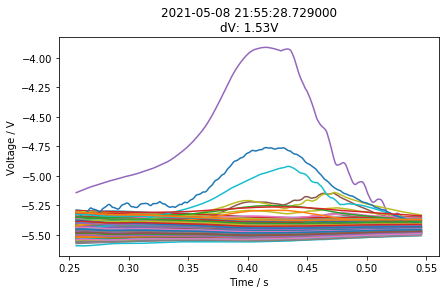

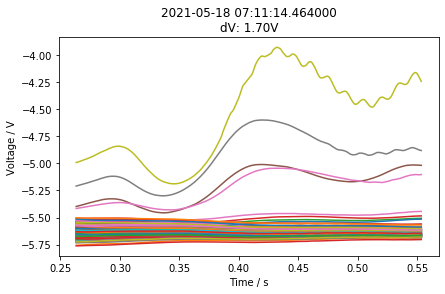

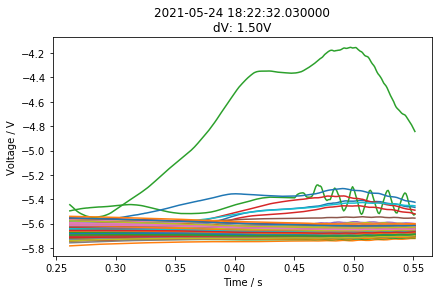

In [12]:
i = 0
max_deviation = np.zeros(len(mp3_fpa_df_in_dataset))
for k, row in mp3_fpa_df_in_dataset.iterrows():

    d = dataset['data'].loc[{'event': row['fpa_identifier']}]#, 'time':slice(t_ee1 + window[0],t_ee1+ window[1])}]
    d = pd.DataFrame(d.values.T, index=d.time.values).rolling(20).mean()
  
    max_deviation[i] = max(abs(d.min().min() - d.mean().mean()), abs(d.max().max() - d.mean().mean()))
    
    if max_deviation[i] > 1.5:
        plt.figure()
        plt.title(f"{row['Timestamp_PIC']}\ndV: {max_deviation[i]:.2f}V")
        plt.tight_layout()
        plt.xlabel('Time / s')
        plt.ylabel('Voltage / V')
        print(row['fpa_identifier'])
        plt.plot(d.index.values, d.values)
        
    i+=1

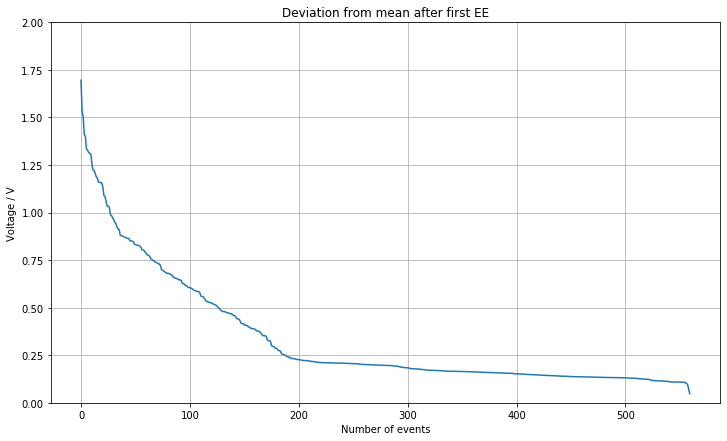

In [13]:
plt.figure(figsize=(12,7))
plt.plot(np.sort(max_deviation)[::-1])
plt.title('Deviation from mean after first EE')
plt.xlabel("Number of events")
plt.ylabel("Voltage / V")
plt.ylim((0,2))
plt.grid()

# fft

In [11]:
dataset_scaled = dataset.copy(deep=True)
dataset_scaled = ds.train_valid_test_split(dataset=dataset_scaled)
dataset_scaled = ds.scale_dataset(dataset=dataset_scaled)

In [165]:
from scipy import signal
from scipy.fft import fft, fftfreq, rfft
from matplotlib import colors

def complex_to_polar(x):
    amplitude = np.abs(x)
    phase = np.arctan2(np.imag(x), np.real(x))  # *180/np.pi
    return amplitude, phase

def get_fft_amplitude(x):
    N = len(x)
    
    if np.isnan(x).all():
        y_FFT = fft(np.nan_to_num(x))
        y_FFT = np.zeros_like(y_FFT) * np.nan
    else:
        x = x[~np.isnan(x)]
        x = x * np.hanning(len(x))
        #x = pd.DataFrame(x).rolling(3).median().values.reshape(-1) #salt and peper noise
        y_FFT = fft(np.nan_to_num(x))
    return 2.0 / N * np.abs(y_FFT[0:N // 2])

def get_fft_phase(DC_Down_data):
    N = len(DC_Down_data)
    x = fft(DC_Down_data)
    return np.arctan2(np.imag(x), np.real(x))[0:N // 2]

def plot_circuit_frequencies_t(ax, x_fft, frequency):
    im = ax.imshow(x_fft, extent=[frequency.min(),frequency.max(),1,154], vmin=0.001, vmax=1, aspect='auto', norm=colors.LogNorm(), origin='lower')
    
    ax.set_xlabel('Frequency / Hz')
    ax.set_ylabel('El. Position')
    ax.set_yticks(np.arange(1,155)[::9])

    cbar = fig.colorbar(im, pad=0.1)
    cbar.set_label('Scaled Voltage')

    ax2 = ax.twinx()
    ax2.set_ylabel('Phys. Position')
    phys_pos = np.hstack((abs(np.arange(-154,0,2)),np.arange(1,155,2)))[::9]
    ax2.set_yticks(np.arange(len(phys_pos)))
    ax2.set_yticklabels(phys_pos)

    plt.tight_layout()
    return ax

def plot_circuit_frequencies_phys_pos(ax, x_fft, frequency):
        
    phys_pos = np.hstack((abs(np.arange(-154,0,2)),np.arange(1,155,2)))
    el_pos = np.argsort(phys_pos)+1
    
    im = ax.imshow(x_fft[el_pos-1].T, extent=[1,154, frequency.min(),frequency.max()], vmin=0.0001, vmax=1, aspect='auto', norm=colors.LogNorm(), origin='lower')
    ax.set_ylabel('Frequency / Hz')
    ax.set_xlabel('Phy. Position')
    ax.set_xticks(np.arange(1,155)[::9])
    #plt.title('Frequency Domain')

    #cbar = fig.colorbar(im, ax=ax)
    #cbar.set_label('Voltage')

    
    plt.tight_layout()
    return im

def plot_circuit_frequencies(ax, x_fft, frequency):
    im = ax.imshow(x_fft.T, extent=[1,154, frequency.min(),frequency.max()], vmin=0.0001, vmax=1, aspect='auto', norm=colors.LogNorm(), origin='lower')
    
    ax.set_ylabel('Frequency / Hz')
    ax.set_xlabel('El. Position')
    ax.set_xticks(np.arange(1,155)[::9])



    #ax2.set_ylabel('Phys. Position')
    #phys_pos = np.hstack((abs(np.arange(-154,0,2)),np.arange(1,155,2)))[::9]
    #ax2.set_yticks(np.arange(len(phys_pos)))
    #ax2.set_yticklabels(phys_pos)

    plt.tight_layout()
    return im


# Signal vs. scaled signal

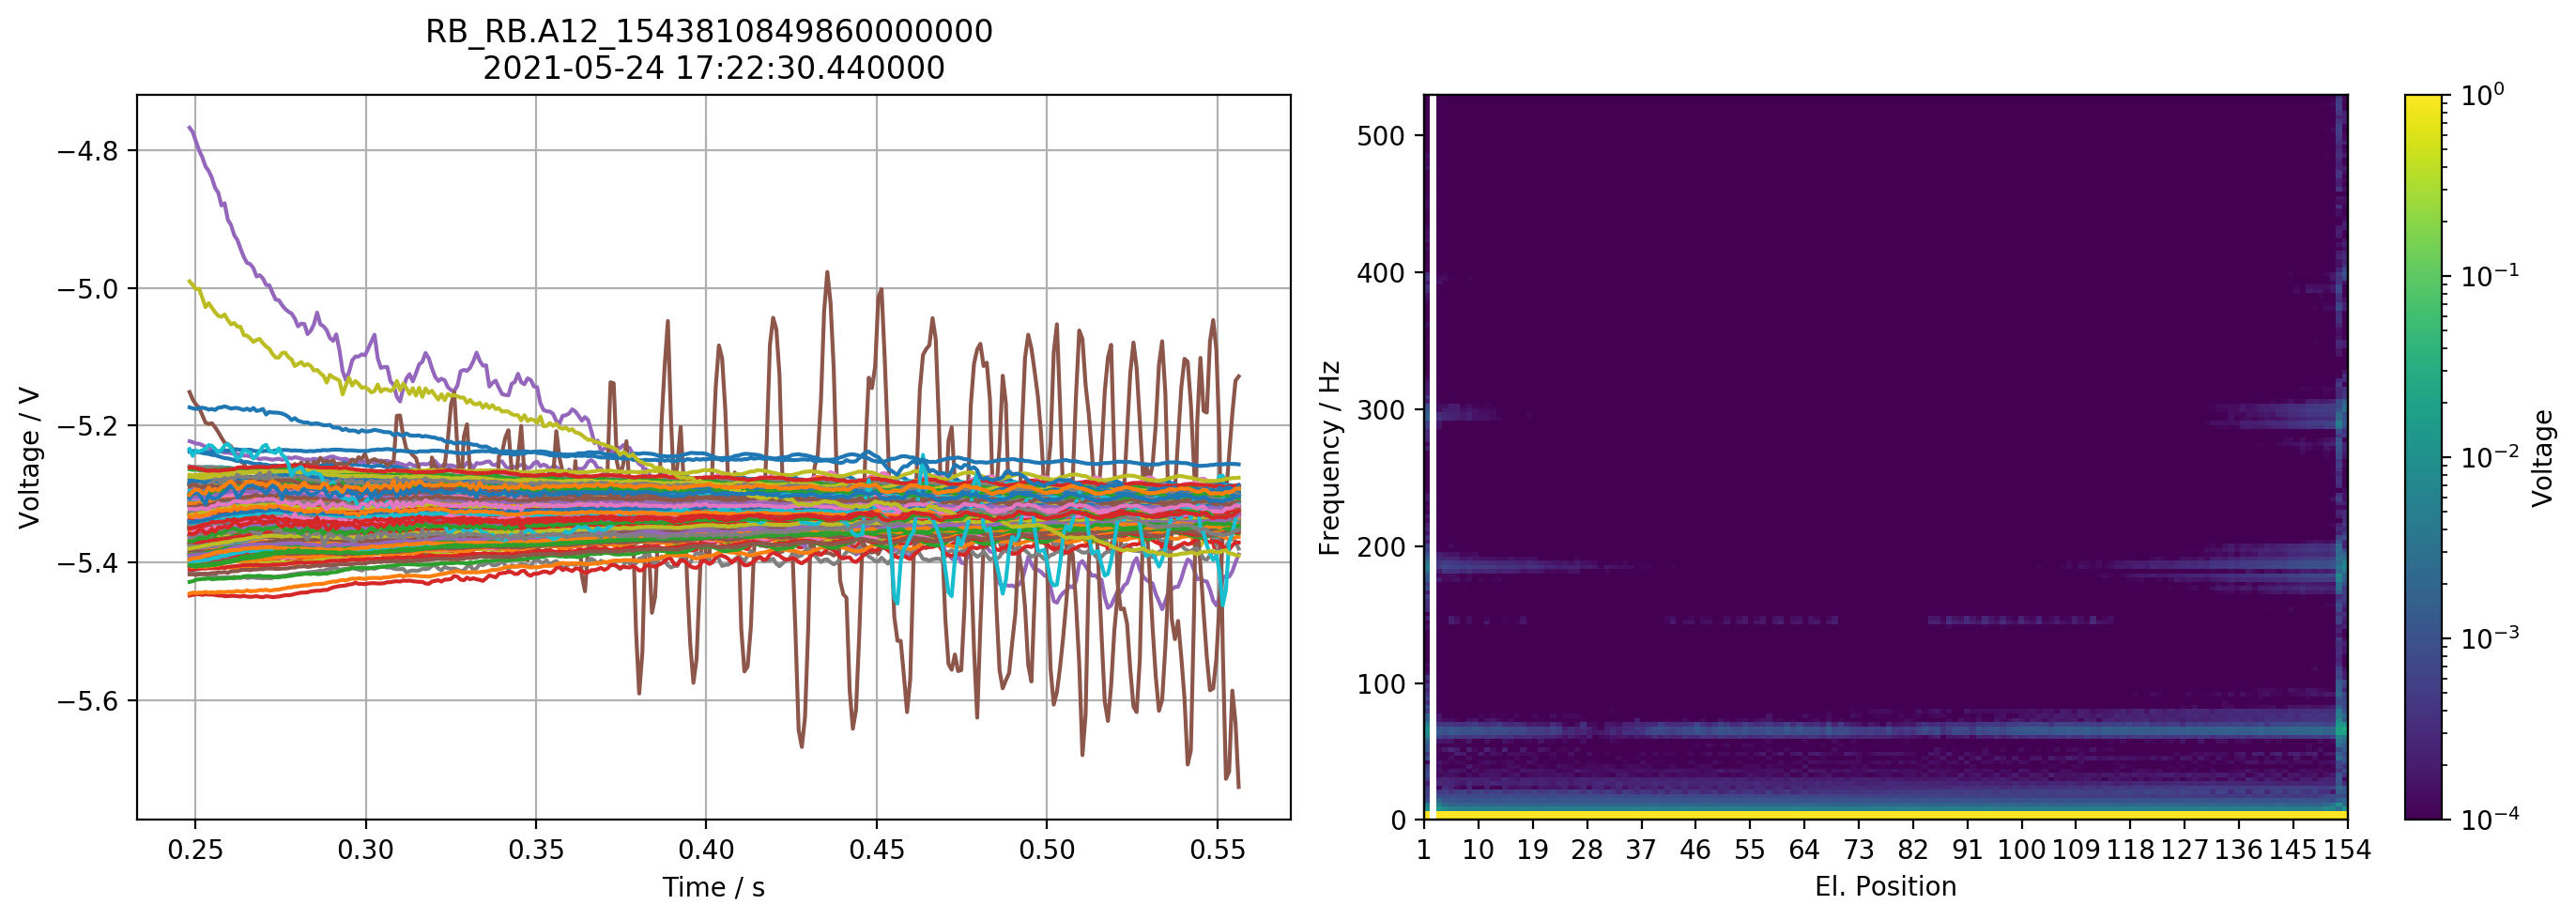

In [161]:
event=0
fpa_identifier =  dataset[{'event': event}].event.values

x_time = dataset[{'event': event}].data.values
x_fft = np.array([get_fft_amplitude(x) for x in x_time])
dt= dataset[{'event': 0}].time[1].values -dataset[{'event': 0}].time[0].values
frequency = fftfreq(len(x_time[0]), dt)[:len(x_time[0])//2] 

fig, ax = plt.subplots(1, 2, figsize=(14,5))
plt.plot(x_time.T)
ax[0].set_title(f"{fpa_identifier} \n{date}")
ax[0].set_xlabel('Time / s')
ax[0].set_ylabel('Voltage / V')
ax[0].plot(dataset.loc[{'event': example}].time, dataset.loc[{'event': example}].data.T)
ax[0].grid()

plot_circuit_frequencies(ax[1], x_fft, frequency)


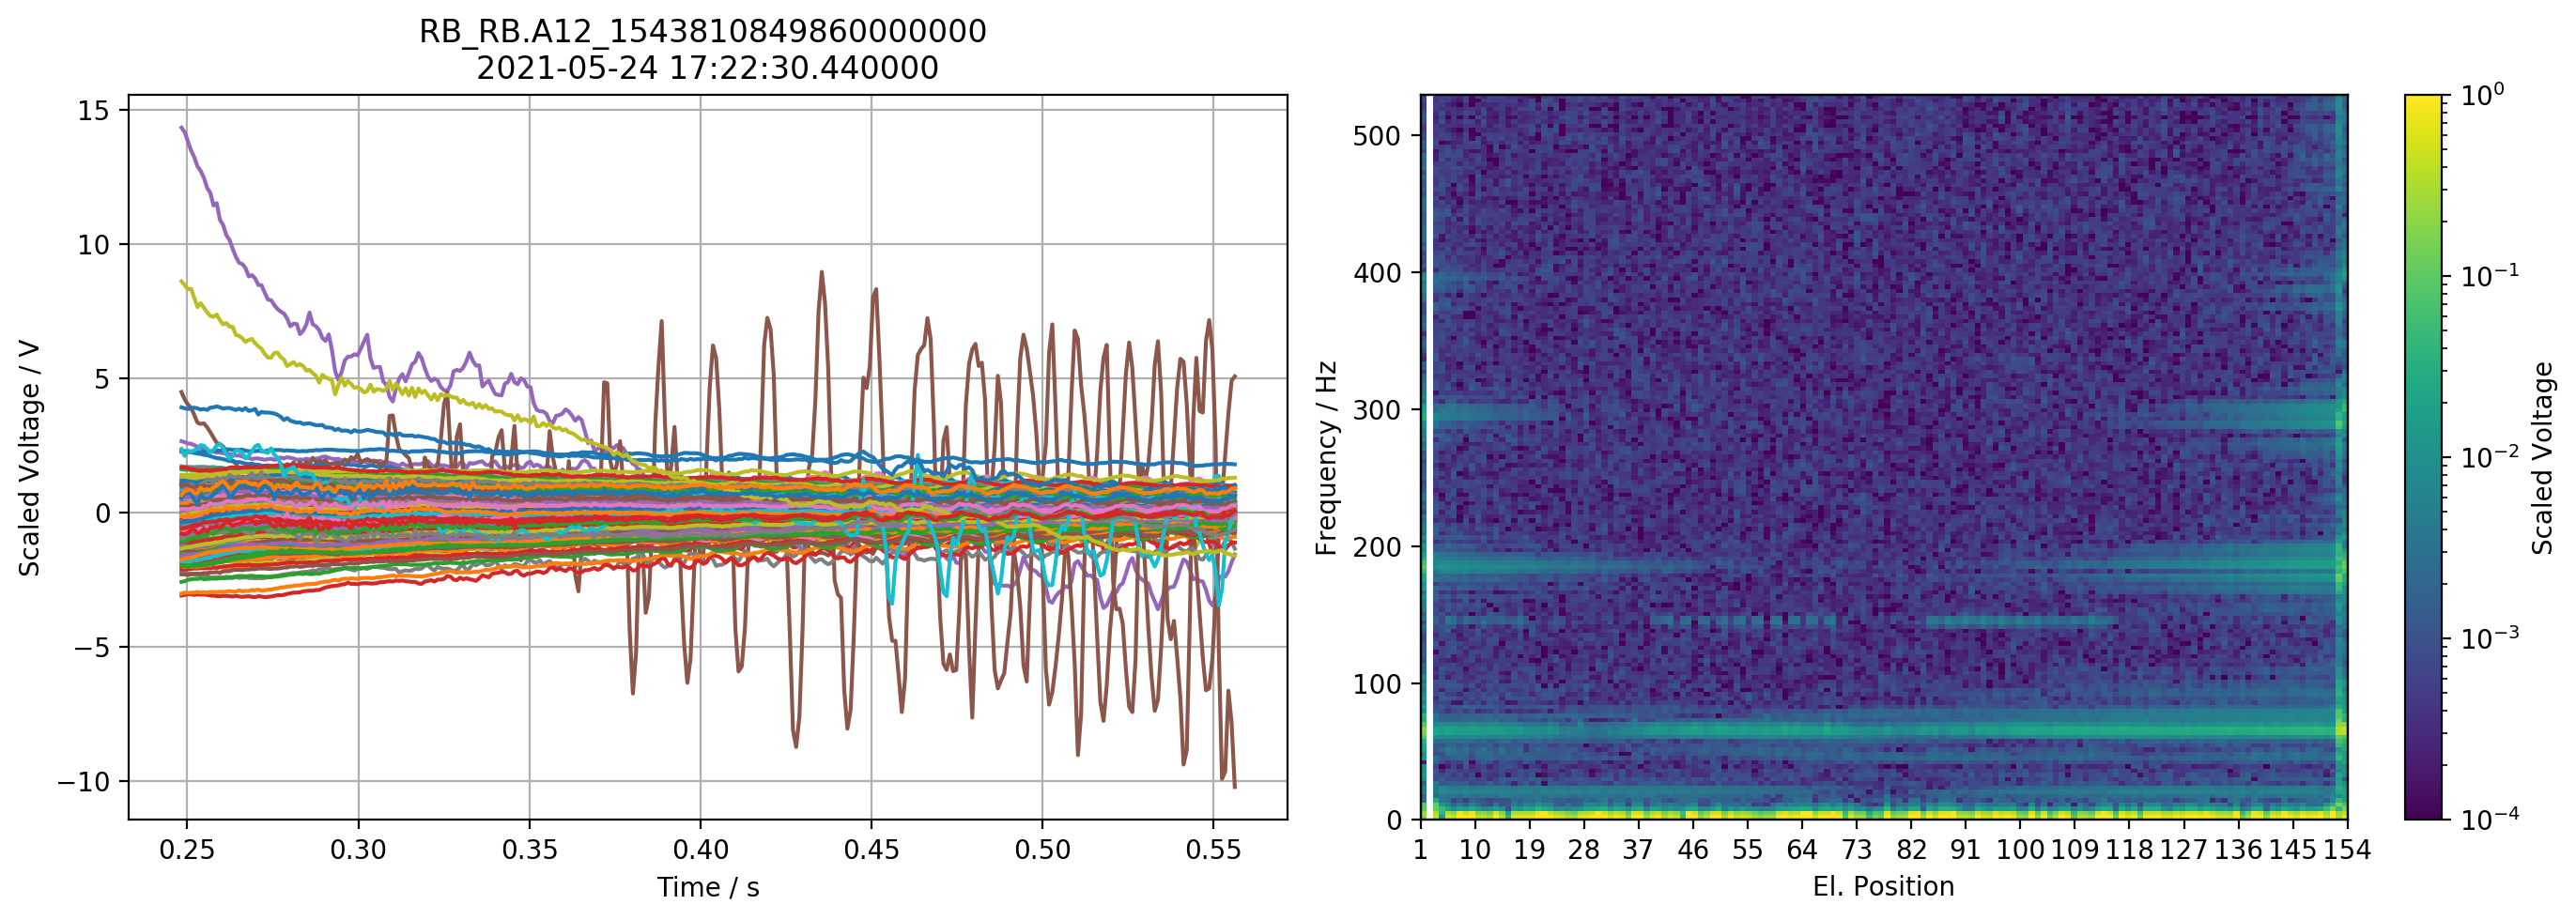

In [153]:
event=0
fpa_identifier =  dataset[{'event': event}].event.values

x_time = dataset_scaled[{'event': event}].data.values
x_fft = np.array([get_fft_amplitude(x) for x in x_time])
dt= dataset[{'event': 0}].time[1].values -dataset[{'event': 0}].time[0].values
frequency = fftfreq(len(x_time[0]), dt)[:len(x_time[0])//2] 

fig, ax = plt.subplots(1, 2, figsize=(14,5))
ax[0].set_title(f"{fpa_identifier} \n{date}")
ax[0].set_xlabel('Time / s')
ax[0].set_ylabel('Scaled Voltage / V')
ax[0].plot(dataset.loc[{'event': example}].time, dataset_scaled.loc[{'event': example}].data.T)
ax[0].grid()

plot_circuit_frequencies(ax[1], x_fft, frequency)

In [ ]:
# Calculate fft of all events

In [76]:
dataset_fft = xr.apply_ufunc(get_fft_amplitude, 
                             dataset.data,
                             input_core_dims=[['time']], 
                             output_core_dims=[['frequency']], 
                             exclude_dims=set(("time",)),
                             vectorize=True)

# Manually analyze fast secondary quenches

In [77]:
fpa_identifiers = mp3_fpa_df[(mp3_fpa_df['Delta_t(iQPS-PIC)'] / 1000 < 1) & 
                             (mp3_fpa_df['Nr in Q event'].astype(str) != '1') &
                             (mp3_fpa_df['timestamp_fgc'] > 1621836512820000000)
                            ].fpa_identifier.unique()
len(fpa_identifiers)


52

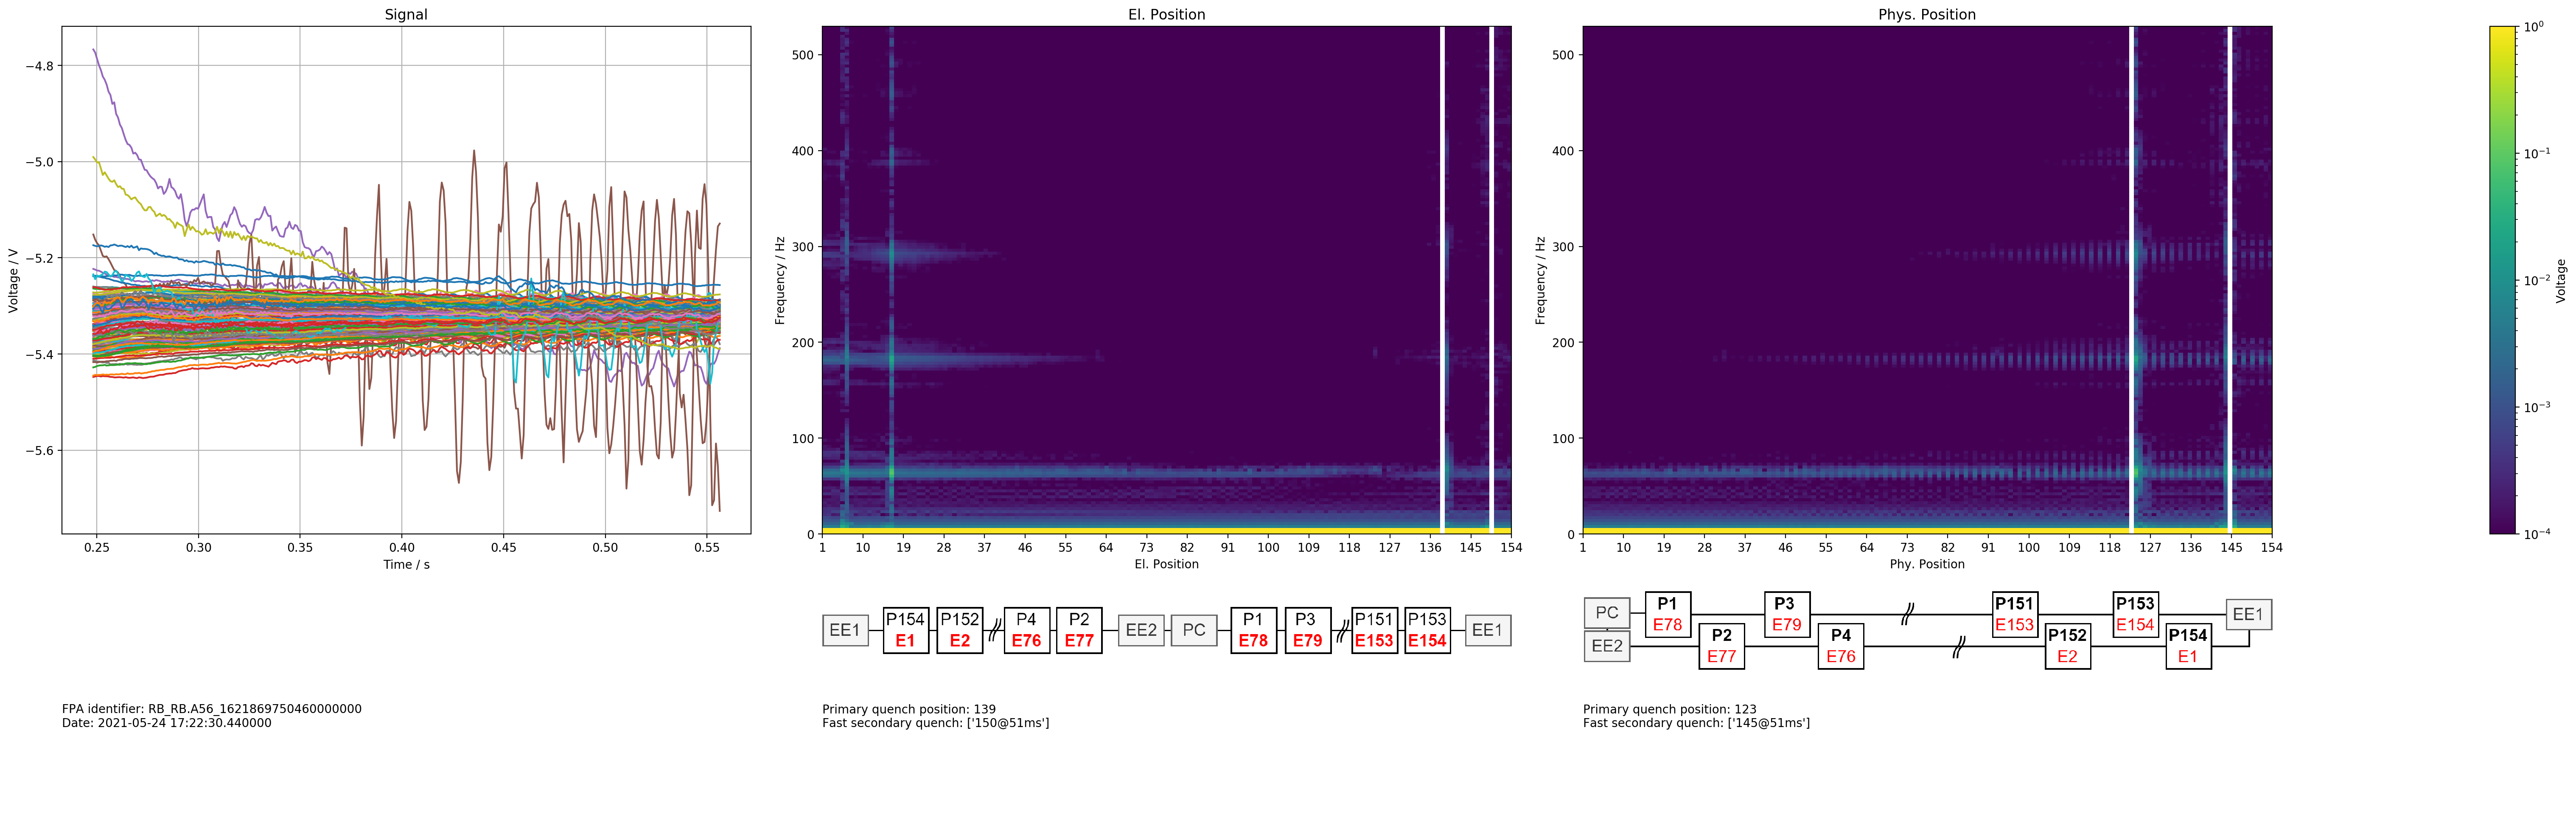

In [177]:
n_examples = 1
img_phys_pos = mpimg.imread('../documentation/phys_pos.png')
img_el_pos = mpimg.imread('../documentation/el_pos.png')

for example in fpa_identifiers[:n_examples]:
    
    fig, ax = plt.subplots(3,4, figsize=(30,10), gridspec_kw={'height_ratios': [6, 1, 1], 'width_ratios': [4, 4, 4, 1]})
    ax[0, 0].plot(dataset.loc[{'event': example}].time, dataset.loc[{'event': example}].data.T)
    fpa_identifier =  dataset.loc[{'event': example}].event.values
    date = mp3_fpa_df[mp3_fpa_df['fpa_identifier'] == fpa_identifier]['Timestamp_PIC'].values[0]
    ax[0, 0].grid()

    mp3_fpa_df_subset = mp3_fpa_df[(mp3_fpa_df['fpa_identifier'] == fpa_identifier)]
    current = mp3_fpa_df_subset['I_end_2_from_data'].values[0]
    mp3_fpa_df_subset_fast = mp3_fpa_df_subset[mp3_fpa_df_subset['Delta_t(iQPS-PIC)'] / 1000 < 1]
    
    prim_quench_position = mp3_fpa_df_subset_fast['#Electric_circuit'].values[0]
    sec_quench_position = mp3_fpa_df_subset_fast['#Electric_circuit'].values[1:]
    
    prim_quench_position_phys = mp3_fpa_df_subset_fast['phys_position'].values[0]
    sec_quench_position_phys = mp3_fpa_df_subset_fast['phys_position'].values[1:]
    sec_quench_times = mp3_fpa_df_subset_fast['Delta_t(iQPS-PIC)'].values[1:] 
    
    sec_quench_phys = [f"{int(pos)}@{int(time)}ms" for pos, time in zip(sec_quench_position_phys, sec_quench_times)]
    sec_quench_el = [f"{int(pos)}@{int(time)}ms" for pos, time in zip(sec_quench_position, sec_quench_times)]
    
    ax[0, 0].set_title(f"Signal")
    ax[0, 0].set_xlabel('Time / s')
    ax[0, 0].set_ylabel('Voltage / V')

    x_fft = dataset_fft.loc[{'event': example}].data
    frequency = fftfreq(len(x_time[0]), dt)[:len(x_time[0])//2]  
    im = plot_circuit_frequencies(ax[0, 1], x_fft, frequency)       
    ax[0, 1].set_title(f'El. Position')
    

    im1 = plot_circuit_frequencies_phys_pos(ax[0, 2], x_fft, frequency)
    ax[0, 2].set_title(f'Phys. Position')
    
    cbar = fig.colorbar(im, ax=ax[0, 3])
    cbar.set_label('Voltage')
    
    ax[1,0].set_axis_off()
    
    ax[1,1].set_axis_off()
    imgplot = ax[1,1].imshow(img_el_pos)
    
    ax[1,2].set_axis_off()
    imgplot = ax[1,2].imshow(img_phys_pos)
    
    ax[2,0].set_axis_off()
    ax[2,1].set_axis_off()
    ax[2,2].set_axis_off()
    
    ax[0,3].set_axis_off()
    ax[1,3].set_axis_off()
    ax[2,3].set_axis_off()
    
    ax[2,0].text(0,1, f"FPA identifier: {fpa_identifier} \nDate: {date} \nMax. Current: {current}")
    ax[2,1].text(0,1, f"Primary quench position: {int(prim_quench_position)} \nFast secondary quench: {sec_quench_el}")
    ax[2,2].text(0,1, f"Primary quench position: {int(prim_quench_position_phys)} \nFast secondary quench: {sec_quench_phys}")

# 2D-tSNE

# look for concepts

In [ ]:
use_fft = 'max'
if use_fft == 'stack':
    X_input_tsne = np.nan_to_num(np.log(dataset_fft.values.reshape(len(dataset_fft.event),-1)))
elif use_fft == 'max':
    X_input_tsne = np.nan_to_num(np.log(dataset_fft.mean(dim=['el_position']).values))
else:
    X_input_tsne = np.nan_to_num(dataset_scaled.data.values.reshape(len(dataset_scaled.event),-1))
    
X_embedded = TSNE(n_components=2).fit_transform(X_input_tsne.astype(np.float32))

In [ ]:
kmeans = KMeans(n_clusters=3, random_state=0).fit(X_embedded)
centers = kmeans.cluster_centers_
k_examples = 3
center_indices=[]

for i, center in enumerate(centers):
    distance = np.linalg.norm(X_embedded - centers[i:i + 1, :], axis=1)
    center_indices.append(np.argsort(distance)[0:k_examples])

In [ ]:
plt.figure(figsize=(7,7))
#plt.grid()

plt.scatter(x=X_embedded[:,0], y=X_embedded[:,1], s=10)
for i, center in enumerate(centers):
    plt.scatter(x=center[0], y=center[1], label=f"center {i}", s=200, marker='*')
    
plt.xlabel('2D-tSNE Axis-1')
plt.ylabel('2D-tSNE Axis-2')
plt.legend()
plt.show()

In [ ]:
mp3_fpa_df_subset = mp3_fpa_df[(mp3_fpa_df['fpa_identifier'] == fpa_identifier)]
mp3_fpa_df_subset[mp3_fpa_df_subset['Delta_t(iQPS-PIC)'] / 1000 < 1] #[['Delta_t(iQPS-PIC)', '#Electric_circuit']]

In [ ]:
for i, examples in enumerate(center_indices):
    for example in examples:
        fig, ax = plt.subplots(1,3, figsize=(20,5))
        ax[0].plot(dataset[{'event': example}].time, dataset[{'event': example}].data.T)
        fpa_identifier =  dataset[{'event': example}].event.values
        date = mp3_fpa_df[mp3_fpa_df['fpa_identifier'] == fpa_identifier]['Timestamp_PIC'].values[0]
        ax[0].grid()
        
        mp3_fpa_df_subset = mp3_fpa_df[(mp3_fpa_df['fpa_identifier'] == fpa_identifier)]
        current = mp3_fpa_df_subset['I_end_2_from_data'].values[0]
        mp3_fpa_df_subset_fast = mp3_fpa_df_subset[mp3_fpa_df_subset['Delta_t(iQPS-PIC)'] / 1000 < 1]
        prim_quench_position = mp3_fpa_df_subset_fast['#Electric_circuit'].values[0]
        sec_quench_position = mp3_fpa_df_subset_fast['#Electric_circuit'].values[1:]
        prim_quench_position_phys = mp3_fpa_df_subset_fast['phys_position'].values[0]
        sec_quench_position_phys = mp3_fpa_df_subset_fast['phys_position'].values[1:]
        
        ax[0].set_title(f"{fpa_identifier} \n{date}")
        ax[0].set_xlabel('Time / s')
        ax[0].set_ylabel('Voltage / V')
        
        x_fft = dataset_fft[{'event': example}].data
        frequency = fftfreq(len(x_time[0]), dt)[:len(x_time[0])//2]  
        ax[1] = plot_circuit_frequencies(ax[1], x_fft, frequency)       
        ax[1].set_title(f'El. Position \n Primary quench position: {int(prim_quench_position)} \n \
                        Fast secondary quench position: {sec_quench_position}')
        
        ax[2] = plot_circuit_frequencies_phys_pos(ax[2], x_fft, frequency)
        ax[2].set_title(f'Phys. Position \n Primary quench position: {int(prim_quench_position_phys)} \n \
                        Fast secondary quench position: {sec_quench_position_phys}')